In [1]:
import torch
import os
import numpy as np
from torch_geometric.data import Data, DataLoader
from VRP.creat_vrp import reward1,creat_instance
from VRP.VRP_Actor import Model

/Users/mvin/Code/DRL-and-graph-neural-network-for-routing-problems/vrptest/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def rollout(model, dataset,n_nodes):
    model.eval()
    def eval_model_bat(bat):
        with torch.no_grad():
            cost, _ = model(bat, n_nodes * 2,True)
            cost = reward1(bat.x,cost.detach(), n_nodes)
        return cost.cpu()
    totall_cost = torch.cat([eval_model_bat(bat.to(device))for bat in dataset], 0)
    return totall_cost

def evaliuate(valid_loder,n_node):
    folder = 'trained'

    agent = Model(3, 128, 1, 16, conv_laysers=4).to(device)
    agent.to(device)

    filepath = os.path.join(folder, '%s' % n_node)

    if os.path.exists(filepath):
        path1 = os.path.join(filepath, 'actor.pt')
        agent.load_state_dict(torch.load(path1, device))
    cost = rollout(agent, valid_loder, n_node)
    cost = cost.mean()
    print('Problem:VRP''%s' % n_node,'/ Average distance:',cost.item())

    cost1=cost.min()

    return cost,cost1



In [3]:

datas = []
n_node = 21
if n_node==21 or n_node==51 or n_node==101:
    node_ = np.loadtxt('VRP/test_data/vrp{}_test_data.csv'.format(n_node-1), dtype=float, delimiter=',')
    demand_ = np.loadtxt('VRP/test_data/vrp{}_demand.csv'.format(n_node-1), dtype=float, delimiter=',')
    capcity_ = np.loadtxt('VRP/test_data/vrp{}_capcity.csv'.format(n_node-1), dtype=float, delimiter=',')
    batch_size=128
else:
    print('Please enter 21, 51 or 101')
node_ = node_.reshape(-1, n_node, 2)
# Calculate the distance matrix
def c_dist(x1,x2):
    return ((x1[0]-x2[0])**2+(x1[1]-x2[1])**2)**0.5
#edges = torch.zeros(n_nodes,n_nodes)

data_size = node_.shape[0]

edges = np.zeros((data_size, n_node, n_node, 1))
for k, data in enumerate(node_):
    for i, (x1, y1) in enumerate(data):
        for j, (x2, y2) in enumerate(data):
            d = c_dist((x1, y1), (x2, y2))
            edges[k][i][j][0] = d
edges_ = edges.reshape(data_size, -1, 1)

edges_index = []
for i in range(n_node):
    for j in range(n_node):
        edges_index.append([i, j])
edges_index = torch.LongTensor(edges_index)
edges_index = edges_index.transpose(dim0=0, dim1=1)

for i in range(1): #номер датафрейма(вроде решается для всех сразу)
    data = Data(x=torch.from_numpy(node_[i]).float(), edge_index=edges_index, edge_attr=torch.from_numpy(edges_[i]).float(),
                demand=torch.tensor(demand_[i]).unsqueeze(-1).float(),
                capcity=torch.tensor(capcity_[i]).unsqueeze(-1).float())
    datas.append(data)



In [4]:

dl = DataLoader(datas, batch_size=128)
evaliuate(dl,n_node)

Problem:VRP21 / Average distance: 9.388959884643555


/Users/mvin/Code/DRL-and-graph-neural-network-for-routing-problems/vrptest/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


(tensor(9.3890), tensor(9.3890))

### matplotlib

In [5]:
import os
import numpy as np
import torch
from VRP.creat_vrp import reward1

from torch_geometric.data import Data,DataLoader
from VRP.VRP_Actor import Model
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_nodes = 11

In [6]:
def discrete_cmap(N, base_cmap=None):
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [7]:
def plot_vehicle_routes(data, route, ax1,Greedy, markersize=5, visualize_demands=False, demand_scale=1, round_demand=False):

    plt.rc('font', family='Times New Roman', size=10)

    routes = [r[r != 0] for r in np.split(route.cpu().numpy(), np.where(route.cpu().numpy() == 0)[0]) if (r != 0).any()]
    depot = data.x[0].cpu().numpy()
    locs = data.x[1:].cpu().numpy()
    demands = data.demand.cpu().numpy()*10
    demands=demands[1:]

    capacity = data.capcity*10

    x_dep, y_dep = depot
    ax1.plot(x_dep, y_dep, 'sk', markersize=markersize * 4)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    legend = ax1.legend(loc='upper center')

    cmap = discrete_cmap(len(routes) + 2, 'nipy_spectral')
    dem_rects = []
    used_rects = []
    cap_rects = []
    qvs = []
    total_dist = 0
    for veh_number, r in enumerate(routes):
        color = cmap(len(routes) - veh_number)  # Invert to have in rainbow order

        route_demands = demands[r - 1]
        coords = locs[r - 1, :]
        xs, ys = coords.transpose()

        total_route_demand = sum(route_demands)
        #assert total_route_demand <= capacity
        if not visualize_demands:
            ax1.plot(xs, ys, 'o', mfc=color, markersize=markersize, markeredgewidth=0.0)

        dist = 0
        x_prev, y_prev = x_dep, y_dep
        cum_demand = 0
        for (x, y), d in zip(coords, route_demands):
            dist += np.sqrt((x - x_prev) ** 2 + (y - y_prev) ** 2)

            cap_rects.append(Rectangle((x, y), 0.01, 0.1))
            used_rects.append(Rectangle((x, y), 0.01, 0.1 * total_route_demand / capacity))
            dem_rects.append(Rectangle((x, y + 0.1 * cum_demand / capacity), 0.01, 0.1 * d / capacity))

            x_prev, y_prev = x, y
            cum_demand += d

        dist += np.sqrt((x_dep - x_prev) ** 2 + (y_dep - y_prev) ** 2)
        total_dist += dist
        qv = ax1.quiver(
            xs[:-1],
            ys[:-1],
            xs[1:] - xs[:-1],
            ys[1:] - ys[:-1],
            scale_units='xy',
            angles='xy',
            scale=1,
            color=color,
            label='R{}, N({}), C {} / {}, D {:.2f}'.format(
                veh_number,
                len(r),
                int(total_route_demand) if round_demand else total_route_demand,
                int(capacity) if round_demand else capacity,
                dist
            )
        )

        qvs.append(qv)
    if Greedy:
        ax1.set_title('Greedy,{} routes, total distance {:.2f}'.format(len(routes), total_dist), family='Times New Roman',size=20)
    else:
        ax1.set_title('Sampling1280,{} routes, total distance {:.2f}'.format(len(routes), total_dist), family='Times New Roman',size=20)

    ax1.legend(handles=qvs)
    plt.legend(loc=1)
    pc_cap = PatchCollection(cap_rects, facecolor='whitesmoke', alpha=1.0, edgecolor='lightgray')
    pc_used = PatchCollection(used_rects, facecolor='lightgray', alpha=1.0, edgecolor='lightgray')
    pc_dem = PatchCollection(dem_rects, facecolor='black', alpha=1.0, edgecolor='black')

    if visualize_demands:
        ax1.add_collection(pc_cap)
        ax1.add_collection(pc_used)
        ax1.add_collection(pc_dem)
    plt.show()
    #plt.savefig("./temp{}.png".format(54), dpi=600, bbox_inches='tight')


In [8]:
def vrp_matplotlib(Greedy=False):

    node_ = np.loadtxt('VRP/test_data/vrp20_test_data.csv', dtype=float, delimiter=',')
    # demand_=np.loadtxt('VRP/test_data/vrp20_demand.csv', dtype=float, delimiter=',')
    demand_=np.loadtxt('VRP/test_data/demand_10.csv', dtype=float, delimiter=';')
    capcity_=np.loadtxt('VRP/test_data/vrp20_capcity.csv', dtype=float, delimiter=',')

    node_ = node_[:11]
    demand_= demand_[:1]
    capcity_ =capcity_[:1]
    # capcity_ = np.array([5.0]) #настройка вместимости транспорта
    node_,demand_=node_.reshape(-1,n_nodes,2),demand_.reshape(-1,n_nodes)
    data_size = node_.shape[0]

    # x=np.random.randint(1,data_size)
    x=0 # выбираем набор данных
    # Calculate the distance matrix
    edges = np.zeros((n_nodes, n_nodes, 1))
    def c_dist(x1, x2):
        return ((x1[0] - x2[0]) ** 2 + (x1[1] - x2[1]) ** 2) ** 0.5
    for i, (x1, y1) in enumerate(node_[x]):
        for j, (x2, y2) in enumerate(node_[x]):
            d = c_dist((x1, y1), (x2, y2))
            edges[i][j][0] = d
    edges_ = edges.reshape(-1, 1)

    edges_index = []
    for i in range(n_nodes):
        for j in range(n_nodes):
            edges_index.append([i, j])
    edges_index = torch.LongTensor(edges_index)
    edges_index = edges_index.transpose(dim0=0, dim1=1)

    datas = []
    data = Data(x=torch.from_numpy(node_[x]).float(), edge_index=edges_index, edge_attr=torch.from_numpy(edges_).float(),
                demand=torch.tensor(demand_[x]).unsqueeze(-1).float(),
                capcity=torch.tensor(capcity_[x]).unsqueeze(-1).float())
    datas.append(data)

    data_loder = DataLoader(datas, batch_size=1)


    agent = Model(3, 128, 1, 16, conv_laysers=4).to(device)
    agent.to(device)
    folder = 'trained'
    filepath = os.path.join(folder, '%s' % n_nodes)

    if os.path.exists(filepath):
        path1 = os.path.join(filepath, 'actor.pt')
        agent.load_state_dict(torch.load(path1, device))
    if Greedy:
        batch = next(iter(data_loder))
        batch.to(device)
        agent.eval()
        #-------------------------------------------------------------------------------------------Greedy
        with torch.no_grad():
            tour, _ = agent(batch, n_nodes * 2,True)
            #cost = reward1(batch.x, tour.detach(), n_nodes)
            #print(cost)
            #print(tour)
    #-------------------------------------------------------------------------------------------sampling1280
    else:
        datas_ = []
        batch_size1 = 128  # sampling batch_size
        for y in range(1280):
            data = Data(x=torch.from_numpy(node_[x]).float(), edge_index=edges_index,
                        edge_attr=torch.from_numpy(edges_).float(),
                        demand=torch.tensor(demand_[x]).unsqueeze(-1).float(),
                        capcity=torch.tensor(capcity_[x]).unsqueeze(-1).float())
            datas_.append(data)
        dl = DataLoader(datas_, batch_size=batch_size1)

        min_tour=[]
        min_cost=100
        T=1.2#Temperature hyperparameters
        for batch in dl:
            with torch.no_grad():
                batch.to(device)
                tour1, _ = agent(batch, n_nodes * 2,False, T)
                cost = reward1(batch.x, tour1.detach(), n_nodes)

                id = np.array(cost.cpu()).argmin()
                m_cost=np.array(cost.cpu()).min()
                tour1=tour1.reshape(batch_size1,-1)
                if m_cost<min_cost:
                    min_cost=m_cost
                    min_tour=tour1[id]

        tour=min_tour.unsqueeze(-2)

    #--------------------------------------------------------------------------------------------
    for i, (data, tour) in enumerate(zip(data_loder, tour)):
        if Greedy:
            print(data.x,data.demand,tour)
            fig, ax = plt.subplots(figsize=(10, 10))
            plot_vehicle_routes(data, tour, ax,Greedy, visualize_demands=False, demand_scale=20, round_demand=True)
        else:
            fig, ax = plt.subplots(figsize=(10, 10))
            plot_vehicle_routes(data, tour, ax,Greedy, visualize_demands=False, demand_scale=50, round_demand=True)


In [9]:
node_ = np.loadtxt('VRP/test_data/vrp20_test_data.csv', dtype=float, delimiter=',')
# demand_=np.loadtxt('VRP/test_data/vrp20_demand.csv', dtype=float, delimiter=',')
demand_=np.loadtxt('VRP/test_data/demand_10.csv', dtype=float, delimiter=';')
capcity_=np.loadtxt('VRP/test_data/vrp20_capcity.csv', dtype=float, delimiter=',')


In [10]:
node_ = node_[:11]
demand_= demand_[:1]
capcity_ =capcity_[:1]

node_,demand_=node_.reshape(-1,n_nodes,2),demand_.reshape(-1,n_nodes)
data_size = node_.shape[0]
data_size

1

In [12]:
x=0

# Calculate the distance matrix
edges = np.zeros((n_nodes, n_nodes, 1))
def c_dist(x1, x2):
    return ((x1[0] - x2[0]) ** 2 + (x1[1] - x2[1]) ** 2) ** 0.5
for i, (x1, y1) in enumerate(node_[x]):
    for j, (x2, y2) in enumerate(node_[x]):
        d = c_dist((x1, y1), (x2, y2))
        edges[i][j][0] = d
edges_ = edges.reshape(-1, 1)

edges_index = []
for i in range(n_nodes):
    for j in range(n_nodes):
        edges_index.append([i, j])
edges_index = torch.LongTensor(edges_index)
edges_index = edges_index.transpose(dim0=0, dim1=1)

datas = []
data = Data(x=torch.from_numpy(node_[x]).float(), edge_index=edges_index, edge_attr=torch.from_numpy(edges_).float(),
            demand=torch.tensor(demand_[x]).unsqueeze(-1).float(),
            capcity=torch.tensor(capcity_[x]).unsqueeze(-1).float())
datas.append(data)

data_loder = DataLoader(datas, batch_size=1)



/Users/mvin/Code/DRL-and-graph-neural-network-for-routing-problems/vrptest/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/h8/0wmx2zx90bn60jw8zc1r4qjc0000gn/T/ipykernel_6958/639031459.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap)
/var/folders/h8/0wmx2zx90bn60jw8zc1r4qjc0000gn/T/ipykernel_6958/271386343.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(total_route_demand) if round_demand else total_route_demand,


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

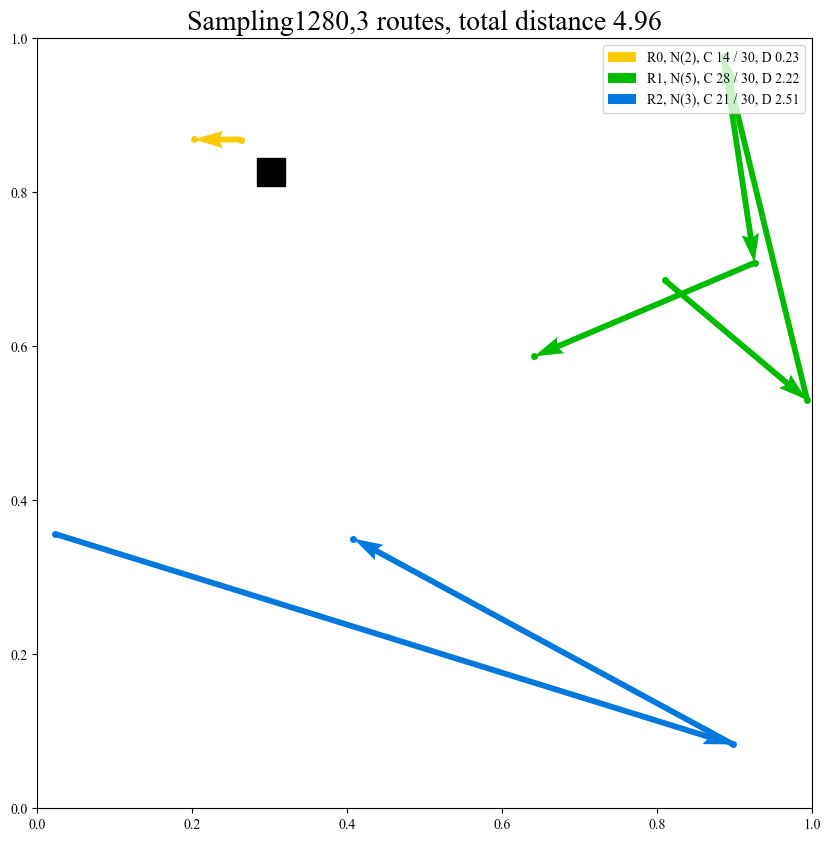

In [24]:

#True:Greedy decoding / False:sampling1280
vrp_matplotlib(Greedy=False)

### OR-Tools

In [47]:
"""Capacited Vehicles Routing Problem (CVRP)."""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [29]:
node_ = np.loadtxt('VRP/test_data/vrp20_test_data.csv', dtype=float, delimiter=',')
# demand_=np.loadtxt('VRP/test_data/vrp20_demand.csv', dtype=float, delimiter=',')
demand_=np.loadtxt('VRP/test_data/demand_10.csv', dtype=float, delimiter=';')
capcity_=np.loadtxt('VRP/test_data/vrp20_capcity.csv', dtype=float, delimiter=',')

In [30]:
node_ = node_[:11]
demand_= demand_[:1]
capcity_ =capcity_[:1]


In [31]:
import numpy as np

coordinates = node_

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

n = coordinates.shape[0]
distance_matrix = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        distance_matrix[i,j] = euclidean_distance(coordinates[i], coordinates[j])

# Округлите значения до целых чисел
rounded_distance_matrix = np.round(distance_matrix * 10).astype(int)

# Преобразуйте матрицу в список списков
distance_matrix = rounded_distance_matrix.tolist()
# distance_matrix_list = distance_matrix.tolist()
print(distance_matrix)


[[0, 1, 6, 5, 6, 10, 1, 5, 5, 4, 8], [1, 0, 7, 5, 7, 10, 1, 6, 6, 5, 9], [6, 7, 0, 10, 3, 6, 7, 6, 1, 3, 2], [5, 5, 10, 0, 11, 9, 6, 4, 9, 7, 10], [6, 7, 3, 11, 0, 9, 6, 8, 3, 5, 5], [10, 10, 6, 9, 9, 0, 10, 6, 6, 6, 5], [1, 1, 7, 6, 6, 10, 0, 5, 6, 5, 8], [5, 6, 6, 4, 8, 6, 5, 0, 5, 3, 6], [5, 6, 1, 9, 3, 6, 6, 5, 0, 2, 2], [4, 5, 3, 7, 5, 6, 5, 3, 2, 0, 4], [8, 9, 2, 10, 5, 5, 8, 6, 2, 4, 0]]


In [50]:
"""Capacited Vehicles Routing Problem (CVRP)."""

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = distance_matrix
    data["demands"] = [0, 5, 5, 8, 9, 8, 9, 5, 9, 3, 2]
    data["vehicle_capacities"] = [30, 30, 30]
    data["num_vehicles"] = 3
    data["depot"] = 0
    return data

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} Load({route_load}) -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print(f"Total distance of all routes: {total_distance}m")
    print(f"Total load of all routes: {total_load}")


def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data["vehicle_capacities"],  # vehicle maximum capacities
        True,  # start cumul to zero
        "Capacity",
    )
  
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_parameters.time_limit.FromSeconds(1)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)

if __name__ == "__main__":
    main()

Objective: 46
Route for vehicle 0:
 0 Load(0) ->  9 Load(3) ->  8 Load(12) ->  4 Load(21) ->  0 Load(21)
Distance of the route: 15m
Load of the route: 21

Route for vehicle 1:
 0 Load(0) ->  3 Load(8) ->  7 Load(13) ->  5 Load(21) ->  10 Load(23) ->  2 Load(28) ->  0 Load(28)
Distance of the route: 28m
Load of the route: 28

Route for vehicle 2:
 0 Load(0) ->  6 Load(9) ->  1 Load(14) ->  0 Load(14)
Distance of the route: 3m
Load of the route: 14

Total distance of all routes: 46m
Total load of all routes: 63
